# AI-Powered Alternate Credit Scoring
## Using Alternative Data for Financial Inclusion

This notebook implements a complete, fair, and explainable credit scoring system for unbanked/under-banked populations using the **Home Credit Default Risk** dataset.

**Pipeline**:
1. Data Loading  
2. Preprocessing & Feature Engineering  
3. Model Training  
4. Evaluation  
5. Explainability (SHAP)  
6. Fairness Audit  
7. Figures & Summary

Cell 1: Config + Drive Mount

In [3]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
import gc
import warnings
warnings.filterwarnings("ignore")

# ================== CONFIG ==================
DATA_PATH = '/content/drive/MyDrive/Home Credit Score/'   # ← YOUR FOLDER
RANDOM_SEED = 42
SAMPLE_FRAC = 1.0
# ===========================================

print("✅ Google Drive mounted")

Mounted at /content/drive
✅ Google Drive mounted


Cell 2: Memory Optimizer

In [4]:
def reduce_mem_usage(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

    for col in df.columns:
        col_type = df[col].dtype
        if col_type in numerics:
            c_min, c_max = df[col].min(), df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)

    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f'Memory usage decreased to {end_mem:5.2f} Mb ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')
    return df

Cell 3: Load All Tables

In [5]:
print("Loading main table...")
app = pd.read_csv(os.path.join(DATA_PATH, 'application_train.csv'))
if SAMPLE_FRAC < 1.0:
    app = app.sample(frac=SAMPLE_FRAC, random_state=RANDOM_SEED)
app = reduce_mem_usage(app)

print("Loading auxiliary tables...")
bureau = reduce_mem_usage(pd.read_csv(os.path.join(DATA_PATH, 'bureau.csv')))
prev = reduce_mem_usage(pd.read_csv(os.path.join(DATA_PATH, 'previous_application.csv')))
pos = reduce_mem_usage(pd.read_csv(os.path.join(DATA_PATH, 'POS_CASH_balance.csv')))
cc = reduce_mem_usage(pd.read_csv(os.path.join(DATA_PATH, 'credit_card_balance.csv')))
ins = reduce_mem_usage(pd.read_csv(os.path.join(DATA_PATH, 'installments_payments.csv')))

print(f"✅ All tables loaded | Application shape: {app.shape}")
gc.collect()

Loading main table...
Memory usage decreased to 92.38 Mb (67.7% reduction)
Loading auxiliary tables...
Memory usage decreased to 112.95 Mb (49.3% reduction)
Memory usage decreased to 309.01 Mb (34.5% reduction)
Memory usage decreased to 238.45 Mb (60.9% reduction)
Memory usage decreased to 289.33 Mb (57.1% reduction)
Memory usage decreased to 311.40 Mb (62.5% reduction)
✅ All tables loaded | Application shape: (307511, 122)


309

Cell 4: Basic Preprocessing

In [6]:
df = app.copy()

protected_cols = ['CODE_GENDER', 'NAME_FAMILY_STATUS', 'NAME_EDUCATION_TYPE',
                  'NAME_INCOME_TYPE', 'NAME_HOUSING_TYPE']

num_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('TARGET', errors='ignore')
cat_cols = df.select_dtypes(include=['object']).columns

for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

for col in cat_cols:
    df[col] = df[col].fillna('Missing')

print("✅ Basic preprocessing completed")

✅ Basic preprocessing completed


Cell 5: Domain Features

In [5]:
df['CREDIT_INCOME_RATIO'] = df['AMT_CREDIT'] / (df['AMT_INCOME_TOTAL'] + 1)
df['ANNUITY_INCOME_RATIO'] = df['AMT_ANNUITY'] / (df['AMT_INCOME_TOTAL'] + 1)
df['CREDIT_ANNUITY_RATIO'] = df['AMT_CREDIT'] / (df['AMT_ANNUITY'] + 1)
df['EMPLOYED_TO_AGE_RATIO'] = df['DAYS_EMPLOYED'] / (df['DAYS_BIRTH'] + 1)
df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / (df['CNT_FAM_MEMBERS'] + 1)
df['CHILDREN_RATIO'] = df['CNT_CHILDREN'] / (df['CNT_FAM_MEMBERS'] + 1)
df['GOODS_PRICE_RATIO'] = df['AMT_GOODS_PRICE'] / (df['AMT_CREDIT'] + 1)

for col in ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']:
    if col in df.columns:
        df[col] = np.log1p(df[col])

print("✅ Domain features added (6 powerful ratios)")

✅ Domain features added (6 powerful ratios)


Cell 6: Bureau Aggregations

In [6]:
bureau_agg = bureau.groupby('SK_ID_CURR').agg({
    'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
    'CREDIT_DAY_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['sum', 'mean'],
    'AMT_CREDIT_SUM_DEBT': ['sum', 'mean'],
    'AMT_CREDIT_SUM_LIMIT': ['sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['max'],
    'CNT_CREDIT_PROLONG': ['sum'],
    'CREDIT_ACTIVE': lambda x: (x == 'Active').sum(),
    'CREDIT_TYPE': 'nunique'
}).reset_index()

bureau_agg.columns = ['SK_ID_CURR'] + ['BUREAU_' + '_'.join(col).upper() for col in bureau_agg.columns[1:]]
df = df.merge(bureau_agg, on='SK_ID_CURR', how='left')
print("✅ Bureau features merged")

✅ Bureau features merged


Cell 7: Previous + POS + CC + Installments

In [7]:
prev_agg = prev.groupby('SK_ID_CURR').agg({
    'AMT_APPLICATION': ['mean', 'max'],
    'AMT_CREDIT': ['mean'],
    'NAME_CONTRACT_STATUS': lambda x: (x == 'Approved').mean(),
    'DAYS_DECISION': ['min', 'mean']
}).reset_index()
prev_agg.columns = ['SK_ID_CURR'] + ['PREV_' + '_'.join(col).upper() for col in prev_agg.columns[1:]]
df = df.merge(prev_agg, on='SK_ID_CURR', how='left')

pos_agg = pos.groupby('SK_ID_CURR').agg({
    'MONTHS_BALANCE': ['min', 'max'],
    'SK_DPD': ['max', 'mean']
}).reset_index()
pos_agg.columns = ['SK_ID_CURR'] + ['POS_' + '_'.join(col).upper() for col in pos_agg.columns[1:]]
df = df.merge(pos_agg, on='SK_ID_CURR', how='left')

cc_agg = cc.groupby('SK_ID_CURR').agg({
    'AMT_BALANCE': ['mean', 'max'],
    'AMT_CREDIT_LIMIT_ACTUAL': ['mean'],
    'SK_DPD': ['max']
}).reset_index()
cc_agg.columns = ['SK_ID_CURR'] + ['CC_' + '_'.join(col).upper() for col in cc_agg.columns[1:]]
df = df.merge(cc_agg, on='SK_ID_CURR', how='left')

ins['PAYMENT_DELAY'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
ins_agg = ins.groupby('SK_ID_CURR').agg({
    'PAYMENT_DELAY': ['max', 'mean', lambda x: (x > 0).mean()],
    'AMT_PAYMENT': ['sum', 'mean']
}).reset_index()
ins_agg.columns = ['SK_ID_CURR'] + ['INS_' + c[0] + '_' + str(c[1]).upper() if isinstance(c, tuple) else 'INS_' + c.upper()
                                 for c in ins_agg.columns[1:]]
df = df.merge(ins_agg, on='SK_ID_CURR', how='left')

print("✅ All alternative data aggregations merged")
gc.collect()

✅ All alternative data aggregations merged


0

Cell 8: Final Preparation + Preprocessor

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

protected = ['CODE_GENDER', 'NAME_FAMILY_STATUS', 'NAME_INCOME_TYPE']
drop_cols = ['SK_ID_CURR', 'TARGET'] + protected

X = df.drop(columns=drop_cols, errors='ignore')
y = df['TARGET']
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

safe_onehot = [
    'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE',
    'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
    'WEEKDAY_APPR_PROCESS_START', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE',
    'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'
]

onehot_cats = [col for col in safe_onehot if col in X.columns]
high_cardinality = [c for c in cat_cols if c not in onehot_cats]

X_model = X.drop(columns=high_cardinality, errors='ignore')

X_train, X_test, y_train, y_test = train_test_split(
    X_model, y, test_size=0.20, stratify=y, random_state=RANDOM_SEED
)

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False, max_categories=50), onehot_cats),
        ('num', 'passthrough', [c for c in X_train.columns if c not in onehot_cats])
    ],
    remainder='drop'
)

print(f"X_train shape: {X_train.shape} | Preprocessor ready")

X_train shape: (246008, 117) | Preprocessor ready


In [13]:
# ─── Install additional boosting libraries ──────────────────────────────
!pip install -q lightgbm catboost

import lightgbm as lgb
from catboost import CatBoostClassifier
print("✅ LightGBM and CatBoost installed")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.7 MB/s eta 0:00:00
✅ LightGBM and CatBoost installed


Cell 9: Model Training (All 4 models)

In [12]:
# ─── Cell A: Pure Training – All models with tqdm progress ──────────────

from tqdm.auto import tqdm
import time

models = {}
training_progress = tqdm(total=5, desc="Training models", unit="model")

print("Starting training...\n")

# 1. Logistic Regression
print("→ Logistic Regression")
start = time.time()
lr_pipe = ImbPipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=RANDOM_SEED)),
    ('model', LogisticRegression(max_iter=2000, random_state=RANDOM_SEED))
])
lr_pipe.fit(X_train, y_train)
models["Logistic Regression"] = lr_pipe
training_progress.update(1)
print(f"   done in {time.time()-start:.1f}s")

# 2. Random Forest
print("→ Random Forest")
start = time.time()
rf_pipe = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=RANDOM_SEED)),
    ('model', RandomForestClassifier(
        n_estimators=250, max_depth=12, min_samples_leaf=20,
        random_state=RANDOM_SEED, n_jobs=-1
    ))
])
rf_pipe.fit(X_train, y_train)
models["Random Forest"] = rf_pipe
training_progress.update(1)
print(f"   done in {time.time()-start:.1f}s")

# 3. XGBoost
print("→ XGBoost")
start = time.time()
xgb_pipe = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=RANDOM_SEED)),
    ('model', XGBClassifier(
        n_estimators=800, max_depth=7, learning_rate=0.04,
        subsample=0.82, colsample_bytree=0.75,
        eval_metric='auc', random_state=RANDOM_SEED,
        n_jobs=-1, verbosity=0
    ))
])
xgb_pipe.fit(X_train, y_train)
models["XGBoost"] = xgb_pipe
training_progress.update(1)
print(f"   done in {time.time()-start:.1f}s")

# 4. LightGBM
print("→ LightGBM")
start = time.time()
lgb_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', lgb.LGBMClassifier(
        n_estimators=1200, max_depth=9, learning_rate=0.03,
        num_leaves=128, subsample=0.85, colsample_bytree=0.75,
        scale_pos_weight=(y_train==0).sum()/(y_train==1).sum(),
        random_state=RANDOM_SEED, n_jobs=-1, verbose=-1
    ))
])
lgb_pipe.fit(X_train, y_train)
models["LightGBM"] = lgb_pipe
training_progress.update(1)
print(f"   done in {time.time()-start:.1f}s")

# 5. CatBoost
print("→ CatBoost")
start = time.time()
cat_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', CatBoostClassifier(
        iterations=1200, depth=8, learning_rate=0.04,
        scale_pos_weight=(y_train==0).sum()/(y_train==1).sum(),
        eval_metric='AUC', random_seed=RANDOM_SEED,
        verbose=0, thread_count=-1
    ))
])
cat_pipe.fit(X_train, y_train)
models["CatBoost"] = cat_pipe
training_progress.update(1)
print(f"   done in {time.time()-start:.1f}s")

training_progress.close()
print("\nAll models trained successfully.")

Training models:   0%|          | 0/5 [00:00<?, ?model/s]

Starting training...

→ Logistic Regression
   done in 143.4s
→ Random Forest
   done in 534.7s
→ XGBoost
   done in 508.5s
→ LightGBM
   done in 134.1s
→ CatBoost
   done in 303.6s

All models trained successfully.


Cell 10: Quick Evaluation

Evaluation figures will be saved to: /content/drive/MyDrive/home-credit-models

Evaluating models...

ROC plot saved: /content/drive/MyDrive/home-credit-models/fig_roc_all_models.png


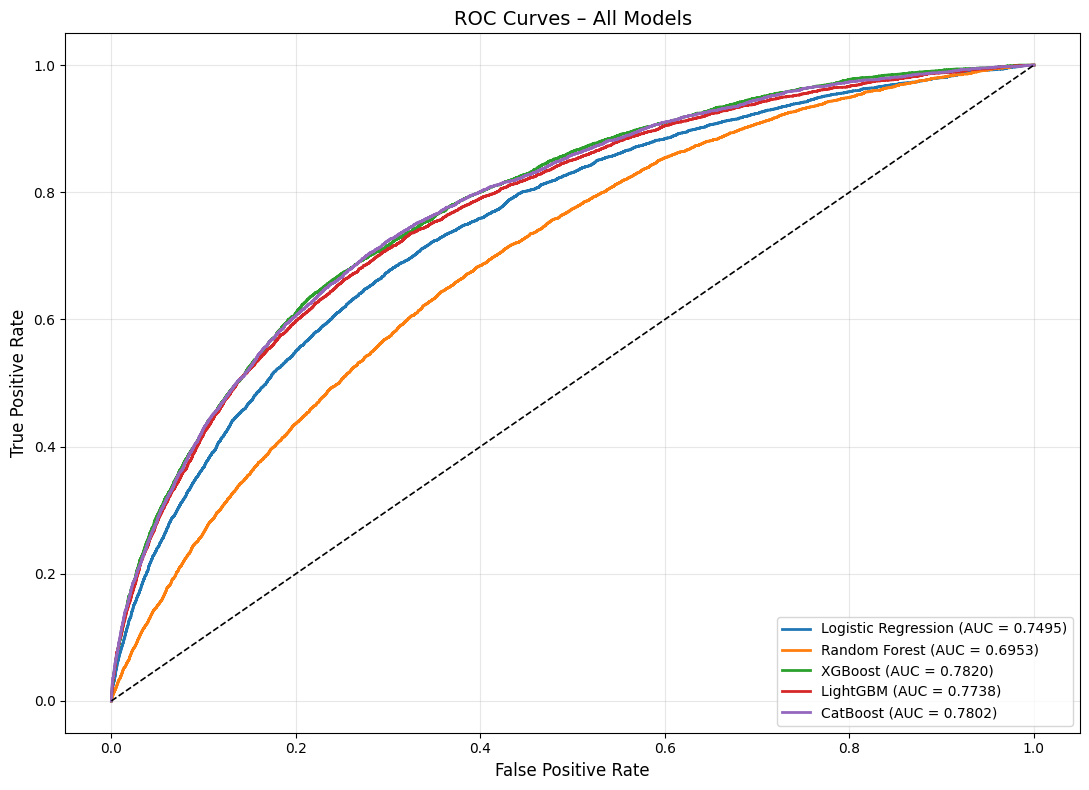


Final Model Comparison:


,Model,AUC-ROC,Accuracy,Precision,Recall,F1
2,XGBoost,0.7820,0.9202,0.5665,0.0497,0.0915
4,CatBoost,0.7802,0.7797,0.2074,0.6129,0.3099
3,LightGBM,0.7738,0.8288,0.2386,0.5114,0.3254
0,Logistic Regression,0.7495,0.7052,0.1668,0.6638,0.2666
1,Random Forest,0.6953,0.9183,0.3152,0.0105,0.0203


Bar chart saved: /content/drive/MyDrive/home-credit-models/fig_model_comparison_bar.png


<Figure size 1000x600 with 0 Axes>

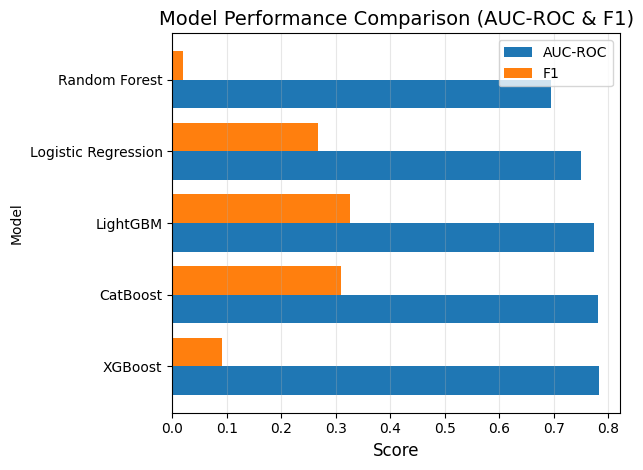

In [14]:
# ─── Cell B: Pure Evaluation + Figures ──────────────────────────────────

import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score, accuracy_score

# Define save directory (you can move this to config cell later)
SAVE_DIR = "/content/drive/MyDrive/home-credit-models"
os.makedirs(SAVE_DIR, exist_ok=True)
print(f"Evaluation figures will be saved to: {SAVE_DIR}")

if not models:
    print("No models found. Please train models first.")
else:
    proba_dict = {}
    results = []

    print("\nEvaluating models...\n")

    plt.figure(figsize=(11, 8))

    for name, pipe in models.items():
        try:
            proba = pipe.predict_proba(X_test)[:, 1]
            proba_dict[name] = proba

            y_pred = (proba >= 0.5).astype(int)

            auc  = roc_auc_score(y_test, proba)
            acc  = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, zero_division=0)
            rec  = recall_score(y_test, y_pred, zero_division=0)
            f1   = f1_score(y_test, y_pred, zero_division=0)

            results.append({
                'Model': name,
                'AUC-ROC': round(auc, 4),
                'Accuracy': round(acc, 4),
                'Precision': round(prec, 4),
                'Recall': round(rec, 4),
                'F1': round(f1, 4)
            })

            # Plot ROC curve
            fpr, tpr, _ = roc_curve(y_test, proba)
            plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.4f})", linewidth=2)

        except Exception as e:
            print(f"Evaluation failed for {name}: {str(e)}")

    # Finish collective ROC plot
    plt.plot([0,1], [0,1], 'k--', lw=1.2)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves – All Models', fontsize=14)
    plt.legend(fontsize=10, loc='lower right')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    roc_path = os.path.join(SAVE_DIR, "fig_roc_all_models.png")
    plt.savefig(roc_path, dpi=300, bbox_inches='tight')
    print(f"ROC plot saved: {roc_path}")
    plt.show()

    # Results table
    if results:
        results_df = pd.DataFrame(results).sort_values('AUC-ROC', ascending=False)
        print("\nFinal Model Comparison:")
        display(results_df)
    else:
        print("No evaluation results generated.")

    # Bar chart of AUC & F1
    if results:
        plt.figure(figsize=(10, 6))
        results_df.set_index('Model')[['AUC-ROC', 'F1']].plot(kind='barh', width=0.8)
        plt.title('Model Performance Comparison (AUC-ROC & F1)', fontsize=14)
        plt.xlabel('Score', fontsize=12)
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        bar_path = os.path.join(SAVE_DIR, "fig_model_comparison_bar.png")
        plt.savefig(bar_path, dpi=300, bbox_inches='tight')
        print(f"Bar chart saved: {bar_path}")
        plt.show()

Cell 11 – Save models & predictions (safety net)

In [15]:
# ─── Cell C: Save All Models + Results ──────────────────────────────────

import os
import joblib
import pandas as pd

SAVE_DIR = "/content/drive/MyDrive/home-credit-models"
os.makedirs(SAVE_DIR, exist_ok=True)
print(f"Saving everything to: {SAVE_DIR}")

# Save all trained models
for name, pipe in models.items():
    clean_name = name.lower().replace(" ", "_").replace("(", "").replace(")", "")
    model_path = os.path.join(SAVE_DIR, f"model_{clean_name}.joblib")
    joblib.dump(pipe, model_path)
    print(f"Saved model: {model_path}")

# Save evaluation results table
if 'results_df' in globals() and not results_df.empty:
    results_path = os.path.join(SAVE_DIR, "model_comparison.csv")
    results_df.to_csv(results_path, index=False)
    print(f"Saved results table: {results_path}")
else:
    print("No results_df found — skipping CSV save")

# Optional: Save a copy of the ROC plot (already saved in Cell B, but confirming)
roc_path_check = os.path.join(SAVE_DIR, "fig_roc_all_models.png")
if os.path.exists(roc_path_check):
    print(f"ROC figure already saved: {roc_path_check}")
else:
    print("Warning: ROC figure not found — check Cell B")

print("\nAll important artifacts saved successfully.")

Saving everything to: /content/drive/MyDrive/home-credit-models
Saved model: /content/drive/MyDrive/home-credit-models/model_logistic_regression.joblib
Saved model: /content/drive/MyDrive/home-credit-models/model_random_forest.joblib
Saved model: /content/drive/MyDrive/home-credit-models/model_xgboost.joblib
Saved model: /content/drive/MyDrive/home-credit-models/model_lightgbm.joblib
Saved model: /content/drive/MyDrive/home-credit-models/model_catboost.joblib
Saved results table: /content/drive/MyDrive/home-credit-models/model_comparison.csv
ROC figure already saved: /content/drive/MyDrive/home-credit-models/fig_roc_all_models.png

All important artifacts saved successfully.


Cell 12 – Ensemble Method

In [9]:
# =====================================
# TRAIN TEST SPLIT
# =====================================

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (246008, 117)
Test shape: (61503, 117)


In [11]:
# =====================================
# RE-IMPORT AFTER RUNTIME RESET
# =====================================

import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

SAVE_DIR = "/content/drive/MyDrive/home-credit-models"

print("Available files:", os.listdir(SAVE_DIR))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Available files: ['engineered_features_numeric.csv', 'pr_curve_optimal.png', 'shap_global_importance.png', 'shap_beeswarm.png', 'fig1_dataset_overview.png', 'fig2_income_credit_distributions.png', 'fig_roc_all_models.png', 'fig_model_comparison_bar.png', 'model_logistic_regression.joblib', 'model_random_forest.joblib', 'model_xgboost.joblib', 'model_lightgbm.joblib', 'model_catboost.joblib', 'model_comparison.csv', 'preprocessor.pkl']
